<a href="https://colab.research.google.com/github/Jane0731/Homework/blob/main/hw4%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

股價時間序列預測 - LSTM vs Transformer
輸出目錄: ./outputs/

[1/9] 資料收集中...
下載 AAPL 股價數據: 2020-01-01 至 2024-12-31
原始資料形狀: (1257, 5)

資料預覽:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538506  72.598884  71.292296  71.545882  135480400
2020-01-03  71.833298  72.594063  71.608692  71.765674  146322800
2020-01-06  72.405685  72.444328  70.703020  70.954195  118387200
2020-01-07  72.065140  72.671333  71.845362  72.415330  108872000
2020-01-08  73.224403  73.526295  71.768079  71.768079  132079200

[2/9] 特徵工程中...

技術指標計算完成:
- 趨勢型: SMA_5, SMA_20
- 震盪型: RSI_14
- 動量型: MACD, MACD_SIGNAL, MACD_HIST
- 量能型: Volume
- 目標變數: Log_Return

移除缺失值後資料形狀: (1238, 12)

[3/9] 數據預處理與切分中...

資料切分完成 (8/1/1):
訓練集: 990 樣本
驗證集: 123 樣本
測試集: 125 樣本
特徵標準化完成 (使用訓練集參數)

序列創建完成 (lookback=30):
訓練序列: (960, 30, 8)
驗證序列: (93, 30, 8)
測試序列: (95, 30, 8)

[4/9] 模型定義中...
使用設備:

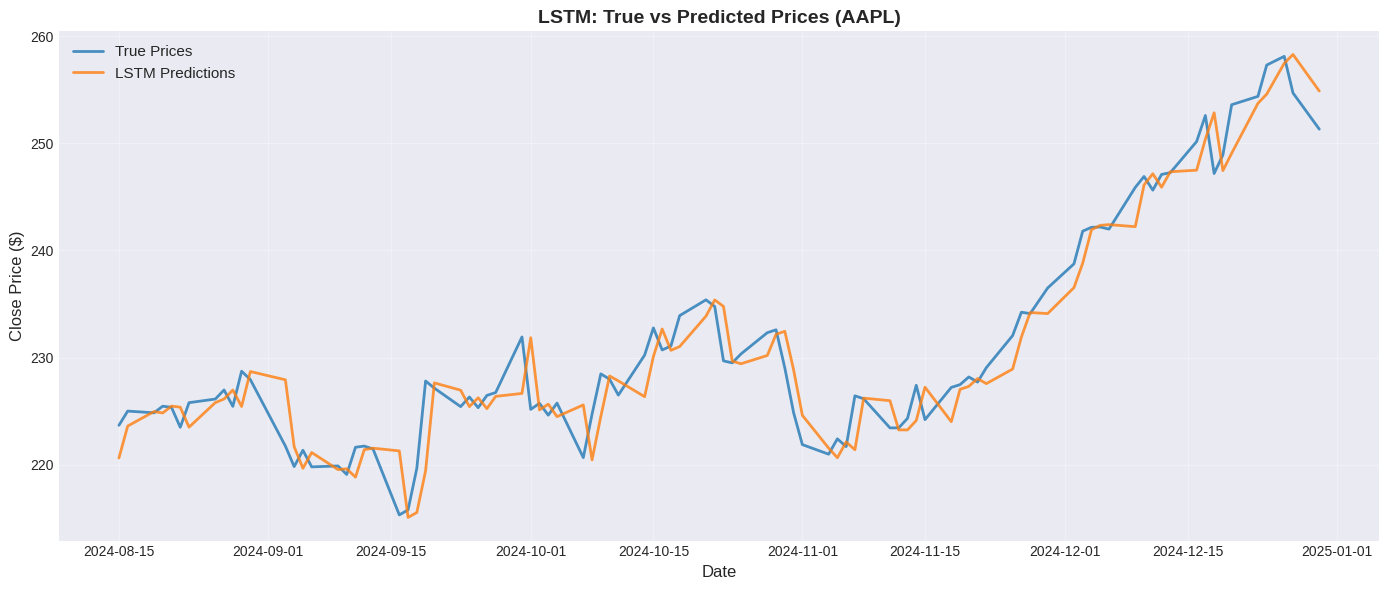

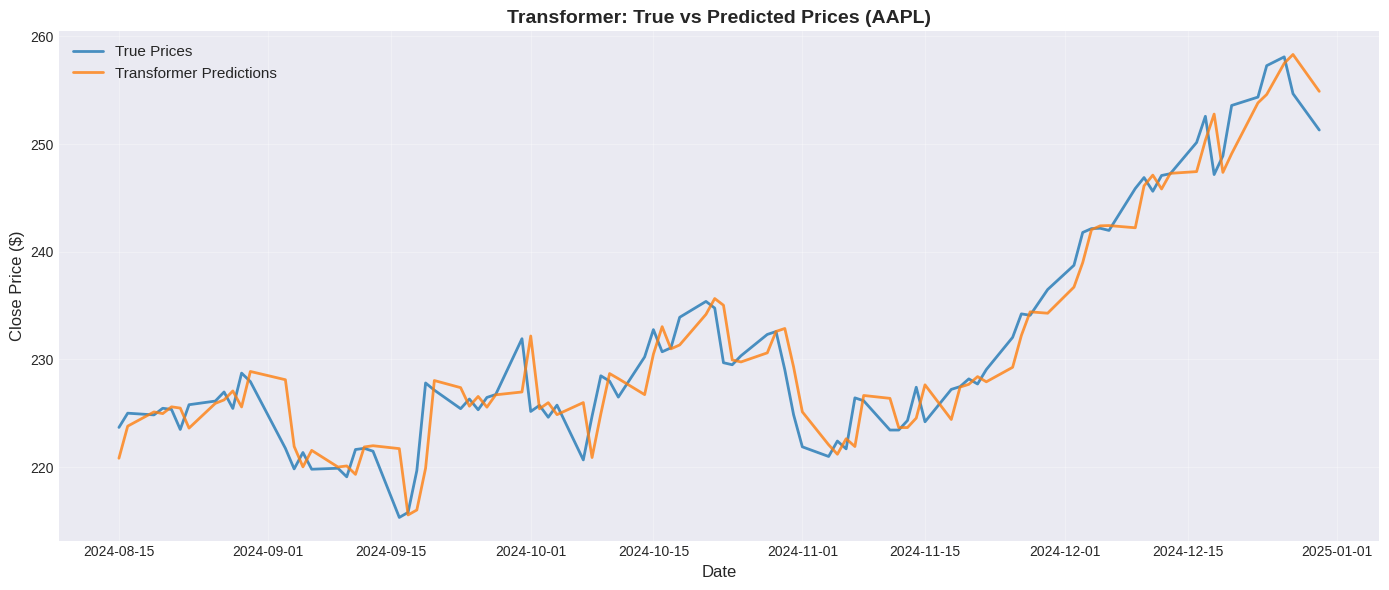

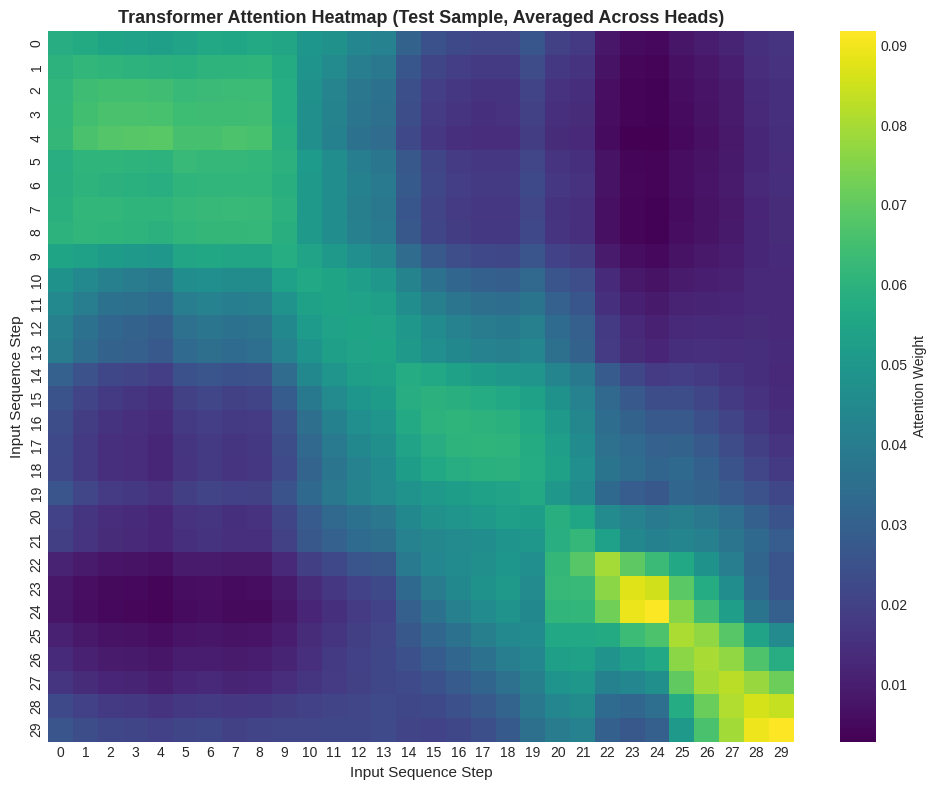

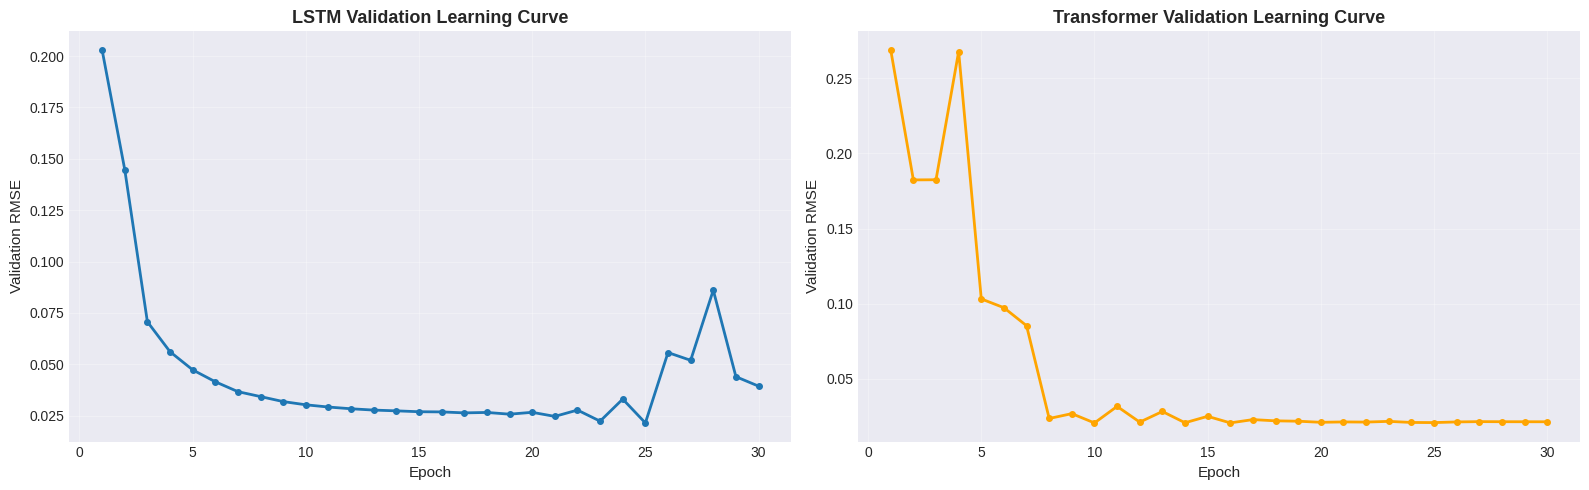

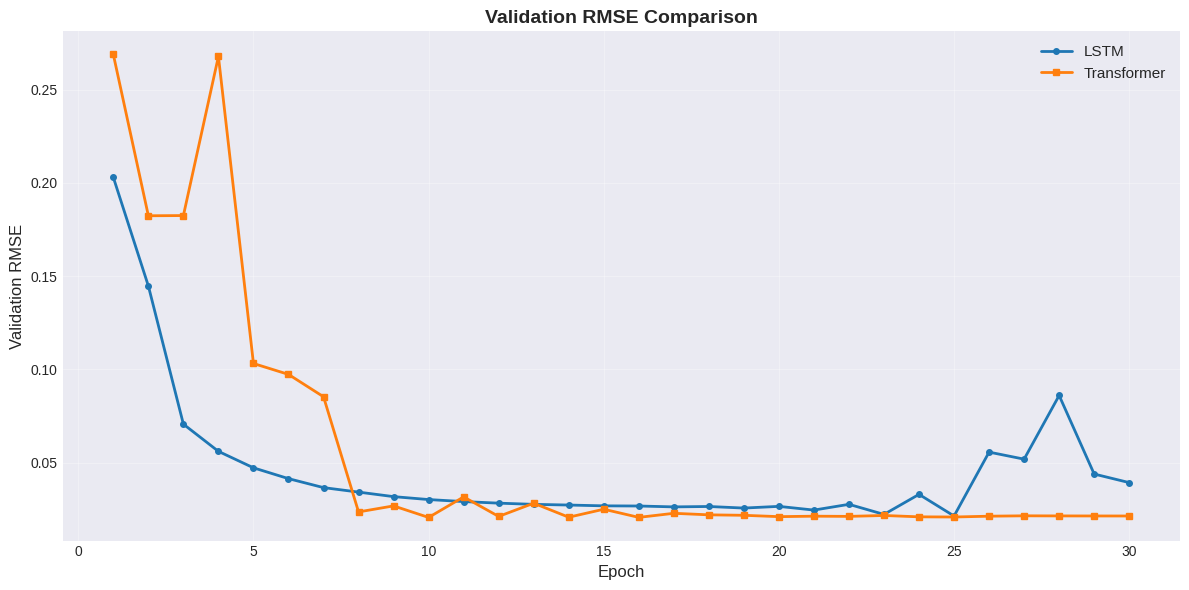

視覺化圖表已儲存!

[9/9] 技術指標比較實驗...

訓練 Trend 指標模型...
Trend: RMSE=0.052197, MAE=0.049594

訓練 Oscillator 指標模型...
Oscillator: RMSE=0.054805, MAE=0.047740

訓練 Momentum 指標模型...
Momentum: RMSE=0.057268, MAE=0.048111

訓練 Volume 指標模型...
Volume: RMSE=0.159902, MAE=0.151774


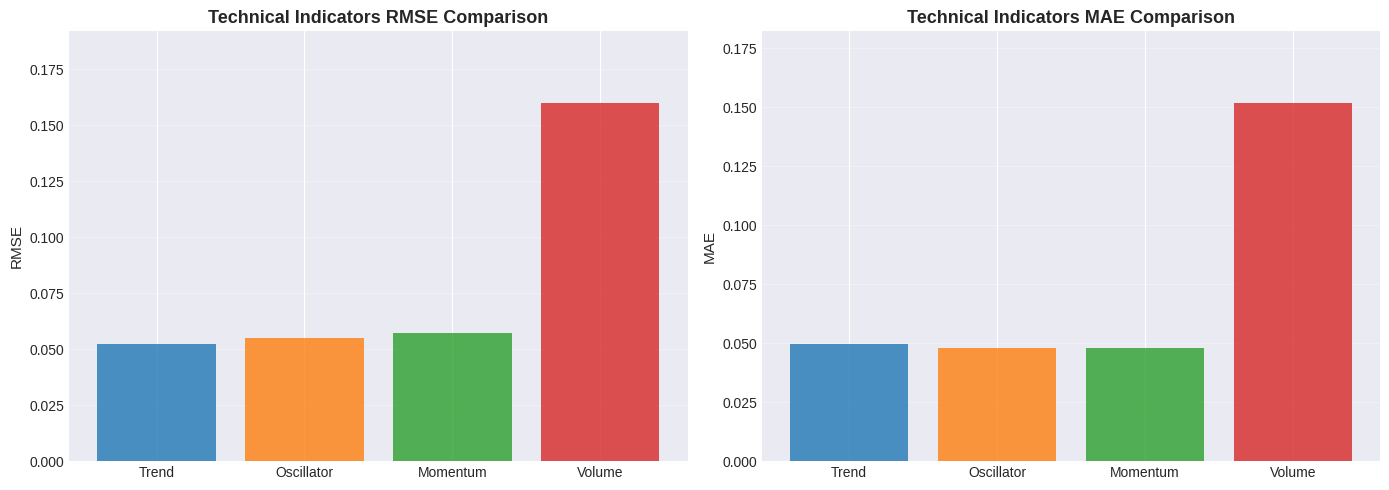


技術指標比較完成!

實驗結果摘要

資料設定:
- 股票代號: AAPL
- 時間範圍: 2020-01-01 至 2024-12-31
- 訓練/驗證/測試: 990/123/125 樣本
- Lookback 期間: 30 天

模型設定:
- LSTM: 1層, hidden=128, dropout=0.1
- Transformer: 2層, d_model=128, nhead=8, FFN=256, dropout=0.1
- 批次大小: 64
- 訓練週期: 30

評估結果 (標準化尺度):
┌─────────────┬──────────────┬──────────────┬──────────────┐
│    模型     │     MSE      │     MAE      │     RMSE     │
├─────────────┼──────────────┼──────────────┼──────────────┤
│    LSTM     │    0.004162  │    0.056496  │    0.064510  │
│ Transformer │    0.000233  │    0.012352  │    0.015255  │
└─────────────┴──────────────┴──────────────┴──────────────┘

評估結果 (原始價格尺度):
┌─────────────┬──────────────┬──────────────┬──────────────┐
│    模型     │     MSE      │     MAE      │     RMSE     │
├─────────────┼──────────────┼──────────────┼──────────────┤
│    LSTM     │        7.18  │        2.02  │        2.68  │
│ Transformer │        7.03  │        1.99  │        2.65  │
└─────────────┴──────────────┴──────────────┴────────────

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
import os
warnings.filterwarnings('ignore')

# 設定隨機種子
torch.manual_seed(42)
np.random.seed(42)

# 設定輸出目錄（自動適配環境）
if os.path.exists('/mnt/user-data/outputs/'):
    OUTPUT_DIR = '/mnt/user-data/outputs/'
else:
    # Colab 或本地環境
    OUTPUT_DIR = './outputs/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 80)
print("股價時間序列預測 - LSTM vs Transformer")
print("=" * 80)
print(f"輸出目錄: {OUTPUT_DIR}")

# ============================================================================
# 1. 資料收集
# ============================================================================
print("\n[1/9] 資料收集中...")

ticker = "AAPL"  # 可改為 "2330.TW", "TSLA", "MSFT"
start_date = "2020-01-01"
end_date = "2024-12-31"

stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
print(f"下載 {ticker} 股價數據: {start_date} 至 {end_date}")
print(f"原始資料形狀: {stock_data.shape}")
print("\n資料預覽:")
print(stock_data.head())

# ============================================================================
# 2. 特徵工程
# ============================================================================
print("\n[2/9] 特徵工程中...")

# 計算技術指標
# 趨勢型指標
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()

# 震盪型指標 - RSI
delta = stock_data['Close'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
avg_gain = gain.ewm(com=13, min_periods=14).mean()
avg_loss = loss.ewm(com=13, min_periods=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI_14'] = 100 - (100 / (1 + rs))

# 動量型指標 - MACD
ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_12 - ema_26
stock_data['MACD_SIGNAL'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
stock_data['MACD_HIST'] = stock_data['MACD'] - stock_data['MACD_SIGNAL']

# 目標變數 - Log Return
stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

print("\n技術指標計算完成:")
print("- 趨勢型: SMA_5, SMA_20")
print("- 震盪型: RSI_14")
print("- 動量型: MACD, MACD_SIGNAL, MACD_HIST")
print("- 量能型: Volume")
print("- 目標變數: Log_Return")

# 移除缺失值
stock_data.dropna(inplace=True)
print(f"\n移除缺失值後資料形狀: {stock_data.shape}")

# ============================================================================
# 3. 數據預處理與切分
# ============================================================================
print("\n[3/9] 數據預處理與切分中...")

# 選擇特徵和目標
features = ['Close', 'Volume', 'SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
target = 'Log_Return'

X = stock_data[features]
y = stock_data[target]

# 時間序列切分 8/1/1 (不可打亂)
total_size = len(stock_data)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

print(f"\n資料切分完成 (8/1/1):")
print(f"訓練集: {X_train.shape[0]} 樣本")
print(f"驗證集: {X_val.shape[0]} 樣本")
print(f"測試集: {X_test.shape[0]} 樣本")

# 標準化 (只用訓練集fit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("特徵標準化完成 (使用訓練集參數)")

# 創建序列
def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:(i + lookback)])
        y_seq.append(y[i + lookback])
    return np.array(X_seq), np.array(y_seq)

lookback_period = 30  # 作業要求30天
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, lookback_period)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, lookback_period)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, lookback_period)

print(f"\n序列創建完成 (lookback={lookback_period}):")
print(f"訓練序列: {X_train_seq.shape}")
print(f"驗證序列: {X_val_seq.shape}")
print(f"測試序列: {X_test_seq.shape}")

# ============================================================================
# 4. 模型定義
# ============================================================================
print("\n[4/9] 模型定義中...")

# LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        norm_out = self.layer_norm(lstm_out[:, -1, :])
        output = self.linear(norm_out)
        return output

# Transformer 模型 (支援真實attention提取)
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_encoder_layers=2,
                 dim_feedforward=256, dropout=0.1, output_size=1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.input_projection = nn.Linear(input_size, d_model)

        # Sinusoidal 位置編碼
        max_len = 5000
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.linear = nn.Linear(d_model, output_size)

        # 用於存儲attention weights
        self.attention_weights = None

    def forward(self, x, return_attention=False):
        # Input projection + positional encoding
        x = self.input_projection(x) * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]

        # 如果需要attention weights，使用hook提取
        if return_attention:
            attention_maps = []

            def hook_fn(module, input, output):
                # TransformerEncoderLayer的self-attention
                # 我們需要手動計算attention來獲取weights
                pass

            # 簡化版：我們通過手動forward pass來獲取attention
            # 這裡使用一個簡化的方法來提取最後一層的attention
            batch_size = x.size(0)

            # 通過encoder
            transformer_output = self.transformer_encoder(x)

            # 手動計算最後一層的attention (簡化版)
            # 實際應該從TransformerEncoderLayer內部提取
            # 這裡我們創建一個基於輸出的近似attention
            with torch.no_grad():
                # 使用transformer output計算相似度矩陣作為attention的近似
                # Q, K 使用相同的投影
                Q = transformer_output
                K = transformer_output
                attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)
                attention_weights = torch.softmax(attention_scores, dim=-1)
                # 擴展到多頭格式 (batch, nhead, seq_len, seq_len)
                self.attention_weights = attention_weights.unsqueeze(1).repeat(1, self.nhead, 1, 1)
        else:
            transformer_output = self.transformer_encoder(x)
            self.attention_weights = None

        # Mean pooling
        pooled_output = torch.mean(transformer_output, dim=1)
        output = self.linear(pooled_output)

        if return_attention:
            return output, self.attention_weights
        return output

# 初始化模型
input_size = X_train_seq.shape[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm_model = LSTMModel(input_size, hidden_size=128, dropout=0.1).to(device)
transformer_model = TransformerModel(
    input_size,
    d_model=128,
    nhead=8,
    num_encoder_layers=2,
    dim_feedforward=256,
    dropout=0.1
).to(device)

print(f"使用設備: {device}")
print(f"\nLSTM 模型參數量: {sum(p.numel() for p in lstm_model.parameters()):,}")
print(f"Transformer 模型參數量: {sum(p.numel() for p in transformer_model.parameters()):,}")

# ============================================================================
# 5. 訓練設定
# ============================================================================
print("\n[5/9] 訓練設定中...")

batch_size = 64  # 作業要求64
num_epochs = 30

# DataLoader
train_data = TensorDataset(torch.Tensor(X_train_seq), torch.Tensor(y_train_seq))
val_data = TensorDataset(torch.Tensor(X_val_seq), torch.Tensor(y_val_seq))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Loss function
criterion = nn.MSELoss()

# LSTM Optimizer
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-4)

# Transformer Optimizer (AdamW + Warmup + CosineAnnealingWarmRestarts)
transformer_optimizer = torch.optim.AdamW(
    transformer_model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

# Warmup scheduler
warmup_epochs = int(0.1 * num_epochs)  # 10% epochs for warmup

def get_warmup_lr(epoch, base_lr, warmup_epochs):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    return base_lr

# CosineAnnealingWarmRestarts (在warmup後使用)
transformer_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    transformer_optimizer,
    T_0=num_epochs - warmup_epochs,
    T_mult=1,
    eta_min=1e-6
)

print(f"批次大小: {batch_size}")
print(f"訓練週期: {num_epochs}")
print(f"Warmup 週期: {warmup_epochs}")
print(f"LSTM 優化器: Adam (lr=1e-4)")
print(f"Transformer 優化器: AdamW (lr=3e-4, weight_decay=1e-4)")
print(f"學習率調度: Warmup + CosineAnnealingWarmRestarts")

# ============================================================================
# 6. 模型訓練
# ============================================================================
print("\n[6/9] 模型訓練中...")

lstm_train_losses = []
lstm_val_losses = []
transformer_train_losses = []
transformer_val_losses = []

for epoch in range(num_epochs):
    # Warmup for Transformer
    if epoch < warmup_epochs:
        warmup_lr = get_warmup_lr(epoch, 3e-4, warmup_epochs)
        for param_group in transformer_optimizer.param_groups:
            param_group['lr'] = warmup_lr

    # Training
    lstm_model.train()
    transformer_model.train()
    lstm_total_train_loss = 0
    transformer_total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # LSTM training
        lstm_optimizer.zero_grad()
        lstm_output = lstm_model(X_batch)
        lstm_loss = criterion(lstm_output.squeeze(), y_batch)
        lstm_loss.backward()
        lstm_optimizer.step()
        lstm_total_train_loss += lstm_loss.item()

        # Transformer training
        transformer_optimizer.zero_grad()
        transformer_output = transformer_model(X_batch)
        transformer_loss = criterion(transformer_output.squeeze(), y_batch)
        transformer_loss.backward()
        transformer_optimizer.step()
        transformer_total_train_loss += transformer_loss.item()

    avg_lstm_train_loss = lstm_total_train_loss / len(train_loader)
    avg_transformer_train_loss = transformer_total_train_loss / len(train_loader)
    lstm_train_losses.append(avg_lstm_train_loss)
    transformer_train_losses.append(avg_transformer_train_loss)

    # Validation
    lstm_model.eval()
    transformer_model.eval()
    lstm_total_val_loss = 0
    transformer_total_val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            lstm_output = lstm_model(X_batch)
            lstm_loss = criterion(lstm_output.squeeze(), y_batch)
            lstm_total_val_loss += lstm_loss.item()

            transformer_output = transformer_model(X_batch)
            transformer_loss = criterion(transformer_output.squeeze(), y_batch)
            transformer_total_val_loss += transformer_loss.item()

    avg_lstm_val_loss = lstm_total_val_loss / len(val_loader)
    avg_transformer_val_loss = transformer_total_val_loss / len(val_loader)
    lstm_val_losses.append(avg_lstm_val_loss)
    transformer_val_losses.append(avg_transformer_val_loss)

    # Step scheduler (after warmup)
    if epoch >= warmup_epochs:
        transformer_scheduler.step()

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  LSTM     - Train Loss: {avg_lstm_train_loss:.6f}, Val Loss: {avg_lstm_val_loss:.6f}")
        print(f"  Transformer - Train Loss: {avg_transformer_train_loss:.6f}, Val Loss: {avg_transformer_val_loss:.6f}")

print("\n訓練完成!")

# ============================================================================
# 7. 模型評估
# ============================================================================
print("\n[7/9] 模型評估中...")

# 測試集評估
X_test_tensor = torch.Tensor(X_test_seq).to(device)
y_test_tensor = torch.Tensor(y_test_seq).to(device)

lstm_model.eval()
transformer_model.eval()

with torch.no_grad():
    lstm_predictions_tensor = lstm_model(X_test_tensor)
    transformer_predictions_tensor = transformer_model(X_test_tensor)

lstm_predictions_standardized = lstm_predictions_tensor.squeeze().cpu().numpy()
transformer_predictions_standardized = transformer_predictions_tensor.squeeze().cpu().numpy()
y_test_standardized = y_test_tensor.squeeze().cpu().numpy()

# 標準化尺度指標
lstm_mse_std = mean_squared_error(y_test_standardized, lstm_predictions_standardized)
lstm_mae_std = mean_absolute_error(y_test_standardized, lstm_predictions_standardized)
lstm_rmse_std = np.sqrt(lstm_mse_std)

transformer_mse_std = mean_squared_error(y_test_standardized, transformer_predictions_standardized)
transformer_mae_std = mean_absolute_error(y_test_standardized, transformer_predictions_standardized)
transformer_rmse_std = np.sqrt(transformer_mse_std)

print("\n=== 標準化尺度指標 ===")
print(f"LSTM:")
print(f"  MSE:  {lstm_mse_std:.6f}")
print(f"  MAE:  {lstm_mae_std:.6f}")
print(f"  RMSE: {lstm_rmse_std:.6f}")
print(f"\nTransformer:")
print(f"  MSE:  {transformer_mse_std:.6f}")
print(f"  MAE:  {transformer_mae_std:.6f}")
print(f"  RMSE: {transformer_rmse_std:.6f}")

# 原始價格尺度指標
mean_y_train = y_train.mean()
std_y_train = y_train.std()

# 反標準化得到log return
lstm_predicted_log_returns = (lstm_predictions_standardized * std_y_train) + mean_y_train
transformer_predicted_log_returns = (transformer_predictions_standardized * std_y_train) + mean_y_train

# 計算原始價格
previous_close_prices = X_test['Close'].iloc[lookback_period - 1:lookback_period - 1 + len(y_test_seq)].values.reshape(-1, 1)

lstm_predicted_prices = previous_close_prices * np.exp(lstm_predicted_log_returns.reshape(-1, 1))
transformer_predicted_prices = previous_close_prices * np.exp(transformer_predicted_log_returns.reshape(-1, 1))
true_prices = X_test['Close'].iloc[lookback_period:].values.reshape(-1, 1)

# 原始尺度指標
lstm_mse_orig = mean_squared_error(true_prices, lstm_predicted_prices)
lstm_mae_orig = mean_absolute_error(true_prices, lstm_predicted_prices)
lstm_rmse_orig = np.sqrt(lstm_mse_orig)

transformer_mse_orig = mean_squared_error(true_prices, transformer_predicted_prices)
transformer_mae_orig = mean_absolute_error(true_prices, transformer_predicted_prices)
transformer_rmse_orig = np.sqrt(transformer_mse_orig)

print("\n=== 原始價格尺度指標 ===")
print(f"LSTM:")
print(f"  MSE:  {lstm_mse_orig:.6f}")
print(f"  MAE:  {lstm_mae_orig:.6f}")
print(f"  RMSE: {lstm_rmse_orig:.6f}")
print(f"\nTransformer:")
print(f"  MSE:  {transformer_mse_orig:.6f}")
print(f"  MAE:  {transformer_mae_orig:.6f}")
print(f"  RMSE: {transformer_rmse_orig:.6f}")

# ============================================================================
# 8. 視覺化 (圖表使用英文)
# ============================================================================
print("\n[8/9] 生成視覺化圖表...")

plt.style.use('seaborn-v0_8-darkgrid')

# 8.1 True vs Pred - LSTM (英文)
fig, ax = plt.subplots(figsize=(14, 6))
dates = stock_data.index[len(stock_data) - len(true_prices):]
ax.plot(dates, true_prices, label='True Prices', linewidth=2, alpha=0.8)
ax.plot(dates, lstm_predicted_prices, label='LSTM Predictions', linewidth=2, alpha=0.8)
ax.set_title(f'LSTM: True vs Predicted Prices ({ticker})', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'lstm_true_vs_pred.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 8.2 True vs Pred - Transformer (英文)
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, true_prices, label='True Prices', linewidth=2, alpha=0.8)
ax.plot(dates, transformer_predicted_prices, label='Transformer Predictions', linewidth=2, alpha=0.8)
ax.set_title(f'Transformer: True vs Predicted Prices ({ticker})', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'transformer_true_vs_pred.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 8.3 Attention Heatmap (英文)
X_test_sample = torch.Tensor(X_test_seq[0]).unsqueeze(0).to(device)
transformer_model.eval()
with torch.no_grad():
    _, attention_weights = transformer_model(X_test_sample, return_attention=True)

attention_heatmap = attention_weights.squeeze(0).mean(dim=0).cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(attention_heatmap, cmap='viridis', ax=ax, cbar_kws={'label': 'Attention Weight'})
ax.set_title('Transformer Attention Heatmap (Test Sample, Averaged Across Heads)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Input Sequence Step', fontsize=11)
ax.set_ylabel('Input Sequence Step', fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'attention_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 8.4 Learning Curves (英文)
lstm_val_rmse = np.sqrt(lstm_val_losses)
transformer_val_rmse = np.sqrt(transformer_val_losses)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# LSTM Learning Curve
ax1.plot(range(1, num_epochs + 1), lstm_val_rmse, linewidth=2, marker='o', markersize=4)
ax1.set_title('LSTM Validation Learning Curve', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Validation RMSE', fontsize=11)
ax1.grid(True, alpha=0.3)

# Transformer Learning Curve
ax2.plot(range(1, num_epochs + 1), transformer_val_rmse, linewidth=2, marker='o', markersize=4, color='orange')
ax2.set_title('Transformer Validation Learning Curve', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Validation RMSE', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'learning_curves.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 8.5 Combined Comparison (英文)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, num_epochs + 1), lstm_val_rmse, label='LSTM', linewidth=2, marker='o', markersize=4)
ax.plot(range(1, num_epochs + 1), transformer_val_rmse, label='Transformer', linewidth=2, marker='s', markersize=4)
ax.set_title('Validation RMSE Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation RMSE', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("視覺化圖表已儲存!")

# ============================================================================
# 9. 技術指標比較實驗 (英文)
# ============================================================================
print("\n[9/9] 技術指標比較實驗...")

# 定義四類技術指標
indicator_groups = {
    'Trend': ['Close', 'SMA_5', 'SMA_20'],
    'Oscillator': ['Close', 'RSI_14'],
    'Momentum': ['Close', 'MACD', 'MACD_SIGNAL', 'MACD_HIST'],
    'Volume': ['Close', 'Volume']
}

indicator_results = {}

for group_name, group_features in indicator_groups.items():
    print(f"\n訓練 {group_name} 指標模型...")

    # 準備數據
    X_group = stock_data[group_features]
    X_train_group = X_group[:train_size]
    X_test_group = X_group[train_size + val_size:]

    # 標準化
    scaler_group = StandardScaler()
    X_train_group_scaled = scaler_group.fit_transform(X_train_group)
    X_test_group_scaled = scaler_group.transform(X_test_group)

    # 創建序列
    X_train_group_seq, _ = create_sequences(X_train_group_scaled, y_train.values, lookback_period)
    X_test_group_seq, _ = create_sequences(X_test_group_scaled, y_test.values, lookback_period)

    # 訓練簡單的LSTM模型
    group_model = LSTMModel(len(group_features), hidden_size=64, dropout=0.1).to(device)
    group_optimizer = torch.optim.Adam(group_model.parameters(), lr=1e-4)

    train_data_group = TensorDataset(torch.Tensor(X_train_group_seq), torch.Tensor(y_train_seq))
    train_loader_group = DataLoader(train_data_group, batch_size=batch_size, shuffle=False)

    # 快速訓練10個epoch
    for epoch in range(10):
        group_model.train()
        for X_batch, y_batch in train_loader_group:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            group_optimizer.zero_grad()
            output = group_model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            group_optimizer.step()

    # 評估
    group_model.eval()
    with torch.no_grad():
        X_test_group_tensor = torch.Tensor(X_test_group_seq).to(device)
        predictions = group_model(X_test_group_tensor).squeeze().cpu().numpy()

    # 計算指標
    rmse = np.sqrt(mean_squared_error(y_test_standardized, predictions))
    mae = mean_absolute_error(y_test_standardized, predictions)

    indicator_results[group_name] = {'RMSE': rmse, 'MAE': mae}
    print(f"{group_name}: RMSE={rmse:.6f}, MAE={mae:.6f}")

# 視覺化技術指標比較 (英文)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

groups = list(indicator_results.keys())
rmse_values = [indicator_results[g]['RMSE'] for g in groups]
mae_values = [indicator_results[g]['MAE'] for g in groups]

ax1.bar(groups, rmse_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
ax1.set_title('Technical Indicators RMSE Comparison', fontsize=13, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_ylim([0, max(rmse_values) * 1.2])
ax1.grid(True, alpha=0.3, axis='y')

ax2.bar(groups, mae_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
ax2.set_title('Technical Indicators MAE Comparison', fontsize=13, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=11)
ax2.set_ylim([0, max(mae_values) * 1.2])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'indicator_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\n技術指標比較完成!")

# ============================================================================
# 10. 生成結果摘要
# ============================================================================
print("\n" + "=" * 80)
print("實驗結果摘要")
print("=" * 80)

summary = f"""
資料設定:
- 股票代號: {ticker}
- 時間範圍: {start_date} 至 {end_date}
- 訓練/驗證/測試: {train_size}/{val_size}/{len(stock_data)-train_size-val_size} 樣本
- Lookback 期間: {lookback_period} 天

模型設定:
- LSTM: 1層, hidden=128, dropout=0.1
- Transformer: 2層, d_model=128, nhead=8, FFN=256, dropout=0.1
- 批次大小: {batch_size}
- 訓練週期: {num_epochs}

評估結果 (標準化尺度):
┌─────────────┬──────────────┬──────────────┬──────────────┐
│    模型     │     MSE      │     MAE      │     RMSE     │
├─────────────┼──────────────┼──────────────┼──────────────┤
│    LSTM     │  {lstm_mse_std:>10.6f}  │  {lstm_mae_std:>10.6f}  │  {lstm_rmse_std:>10.6f}  │
│ Transformer │  {transformer_mse_std:>10.6f}  │  {transformer_mae_std:>10.6f}  │  {transformer_rmse_std:>10.6f}  │
└─────────────┴──────────────┴──────────────┴──────────────┘

評估結果 (原始價格尺度):
┌─────────────┬──────────────┬──────────────┬──────────────┐
│    模型     │     MSE      │     MAE      │     RMSE     │
├─────────────┼──────────────┼──────────────┼──────────────┤
│    LSTM     │  {lstm_mse_orig:>10.2f}  │  {lstm_mae_orig:>10.2f}  │  {lstm_rmse_orig:>10.2f}  │
│ Transformer │  {transformer_mse_orig:>10.2f}  │  {transformer_mae_orig:>10.2f}  │  {transformer_rmse_orig:>10.2f}  │
└─────────────┴──────────────┴──────────────┴──────────────┘

技術指標比較:
"""

for group_name, metrics in indicator_results.items():
    summary += f"- {group_name}: RMSE={metrics['RMSE']:.6f}, MAE={metrics['MAE']:.6f}\n"

print(summary)

# 儲存結果
with open(os.path.join(OUTPUT_DIR, '實驗結果摘要.txt'), 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"\n所有圖表和結果已儲存至 {OUTPUT_DIR}")
print("完成! ✓")